In [1]:
library(tidyverse) # metapackage of all tidyverse packages
library(plyr) ## 문제 dplyr 발생.
library(ggplot2)
library(dplyr) # readxl 
library(reshape2) # Melt

library(scales) # visualisation
library(corrplot) # visualisation
library(GGally) # visualisation
library(ggthemes) # visualisation
library(ggalt) # encircle
library(maps) #maps
library(treemap)
library(ggdendro) # Dendogram

# Interactivity
library(crosstalk)
library(plotly)

#Date
library(scales)
library(zoo)
library(lubridate)

#excel
library(readxl)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object i

In [2]:
## fig
fig=function(x,y){options(repr.plot.width=x,repr.plot.height=y)}

In [3]:
## 확진자 data
## https://sites.google.com/view/snuaric/covid-19/covid-19-data

cases=read_excel("./data/확진자데이터.xlsx")

In [4]:
cases=cases[order(cases$DATE,decreasing=T),] %>% select(-9) 
cases$일일확진자=c(0,diff(cases$누적확진자,1))

cases[cases$DATE==as.Date('2020-01-20'),'일일확진자']=-1
cases$일일확진자=-cases$일일확진자

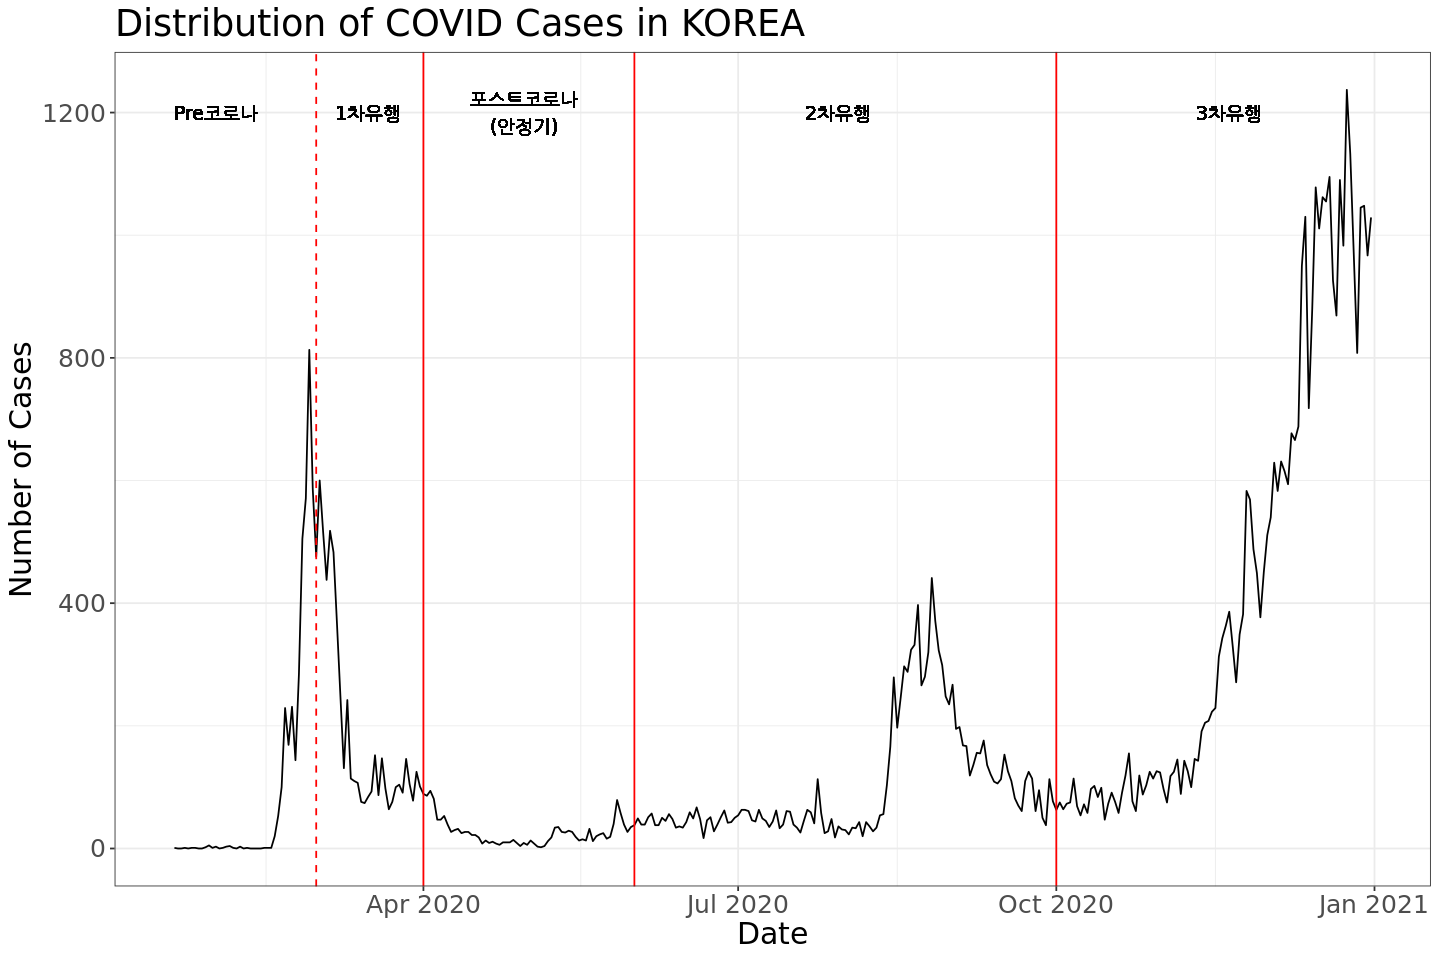

In [5]:
fig(12,8)

ggplot(cases[-c(1),c('DATE','일일확진자')], aes(x=DATE)) + 
  geom_line(aes(y=일일확진자)) + 
    labs(x="Date",
         y="Number of Cases", 
       title="Distribution of COVID Cases in KOREA")+ 
geom_vline(aes(xintercept=as.numeric(cases[-c(1),]$DATE[306])),linetype='dashed',color='red')+
geom_vline(aes(xintercept=as.numeric(cases[-c(1),]$DATE[275])),color='red')+
geom_vline(aes(xintercept=as.numeric(cases[-c(1),]$DATE[214])),color='red')+
geom_vline(aes(xintercept=as.numeric(cases[-c(1),]$DATE[92])),color='red')+
geom_text(aes(x=as.POSIXct('2020-02-01'),y=1200,label='Pre코로나'),size=4)+
geom_text(aes(x=as.POSIXct('2020-03-16'),y=1200,label='1차유행'),size=4)+
geom_text(aes(x=as.POSIXct('2020-04-30'),y=1200,label='포스트코로나\n(안정기)'),size=4)+
geom_text(aes(x=as.POSIXct('2020-07-30'),y=1200,label='2차유행'),size=4)+
geom_text(aes(x=as.POSIXct('2020-11-20'),y=1200,label='3차유행'),size=4)+
theme_bw()+
theme(plot.title = element_text(size=22)
      ,axis.text.x= element_text(size=15),
       axis.text.y= element_text(size=15),
        axis.title=element_text(size=18))

In [6]:
## 유동인구
## 1. 증가율, 유동인구.백만 그래프 이중축. ㅇ

## data
popl=read_csv("./data/2020년 유동인구.csv",locale=locale('ko',encoding='euc-kr'))

mask=(popl$행정동=='성남동'|popl$행정동=='정림동'|popl$행정동=='문창동'|popl$행정동=='대흥동')

월별유동인구=popl[mask,] %>% select(c(-2,-3,-4,-5)) %>% group_by(연월) %>% 
summarise(across(everything(), sum),.groups='drop') %>% select(c(-1)) %>% apply(1,sum)

월별유동인구=tibble(연월=unique(popl$연월),value=월별유동인구)

월별유동인구$증가정도=c(diff(월별유동인구$value,1),0)
월별유동인구$증가율=월별유동인구$증가정도 / 월별유동인구$value * 100
월별유동인구$유동인구.백만=월별유동인구$value/1000000

월별유동인구$월=c('1','2','3','4','5','6','7','8','9','10','11','12')

유동인구=popl[mask,] %>% select(c(-2,-3,-5)) %>% group_by(연월,행정동) %>% 
summarise(across(everything(), sum),.groups='drop') %>% select(c(1,2))
총합=popl[mask,] %>% select(c(-2,-3,-5)) %>% group_by(연월,행정동) %>% 
summarise(across(everything(), sum),.groups='drop') %>% select(c(-1,-2)) %>% rowSums()

유동인구=cbind(유동인구,총합)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  시 = col_character(),
  구 = col_character(),
  행정동 = col_character()
)
ℹ Use `spec()` for the full column specifications.




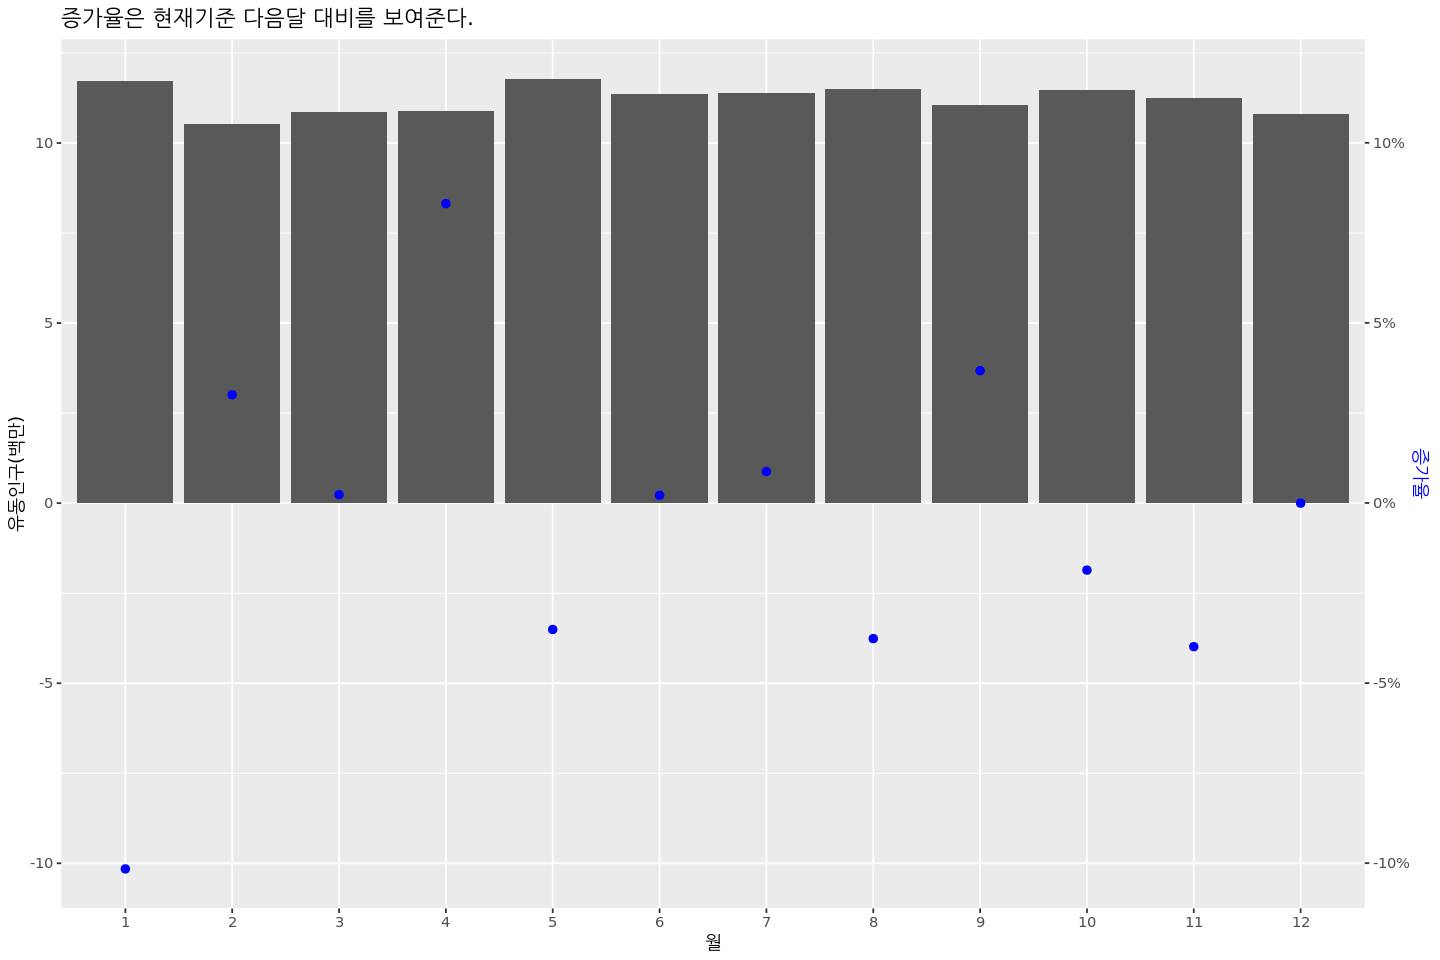

In [7]:
## manual order
월별유동인구copy=월별유동인구
월별유동인구copy$월=factor(월별유동인구copy$월,levels=c('1','2','3','4','5','6','7','8','9','10','11','12'))

ggplot() + 
  geom_bar(mapping = aes(x = 월별유동인구copy$월, y = 월별유동인구copy$유동인구.백만), stat = "identity") +
  geom_point(mapping = aes(x = 월별유동인구copy$월, y = 월별유동인구copy$증가율),size=2,color = "blue") + 
  scale_y_continuous(sec.axis = sec_axis(~., name = "증가율", 
      labels = function(b) { paste0(round(b,0), "%")})) + 
  theme(
      axis.title.y = element_text(color = "grey"),
      axis.title.y.right = element_text(color = "blue"),
      axis.title.y.left = element_text(color='black'))+
  xlab("월") + ylab("유동인구(백만)")+ggtitle("증가율은 현재기준 다음달 대비를 보여준다.")

In [8]:
## card
card=read_excel("./data/동별_대분류_월별매출액.xlsx",skip=1)

names=c('공공_행정_국방_및_사회보장_행정','교육_서비스업','금융_및_보험업','기타','도매_및_소매업','보건업_및_사회복지_서비스업',
            '부동산업','사업시설_관리_사업_지원_및_임대_서비스업','숙박_및_음식점업','예술_스포츠_및_여가관련_서비스업','운수_및_창고업',
            '전문_과학_및_기술_서비스업','정보통신업','제조업','협회_및_단체_수리_및_기타_개인_서비스업')

cols=function(col){
    res=c()
    for (n in col){
        total=paste0(n,'_총액')
        region=paste0(n,'_지역화폐')
        disaster=paste0(n,'_재난지원금')
        credit=paste0(n,'_신용카드')
        
        res=append(res,total)
        res=append(res,region)
        res=append(res,disaster)
        res=append(res,credit)
    }
    return(res)
}

## card colnames
res=cols(names)
res=c(c('년월','구','동'),res)
colnames(card)=res

mask=(card$동=='성남동'|card$동=='정림동'|card$동=='문창동'|card$동=='대흥동') ## 유동인구와 같이 분석하기 때문에 겹치는 동만

교육=card[mask,c(1,3,8,9,10,11)]
여가=card[mask,c(1,3,40,41,42,43)]

숙박음식=card[mask,c(1,3,36,37,38,39)]
운수=card[mask,c(1,3,44,45,46,47)]

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* 총액 -> 총액...4
* 지역화폐 -> 지역화폐...5
* ...



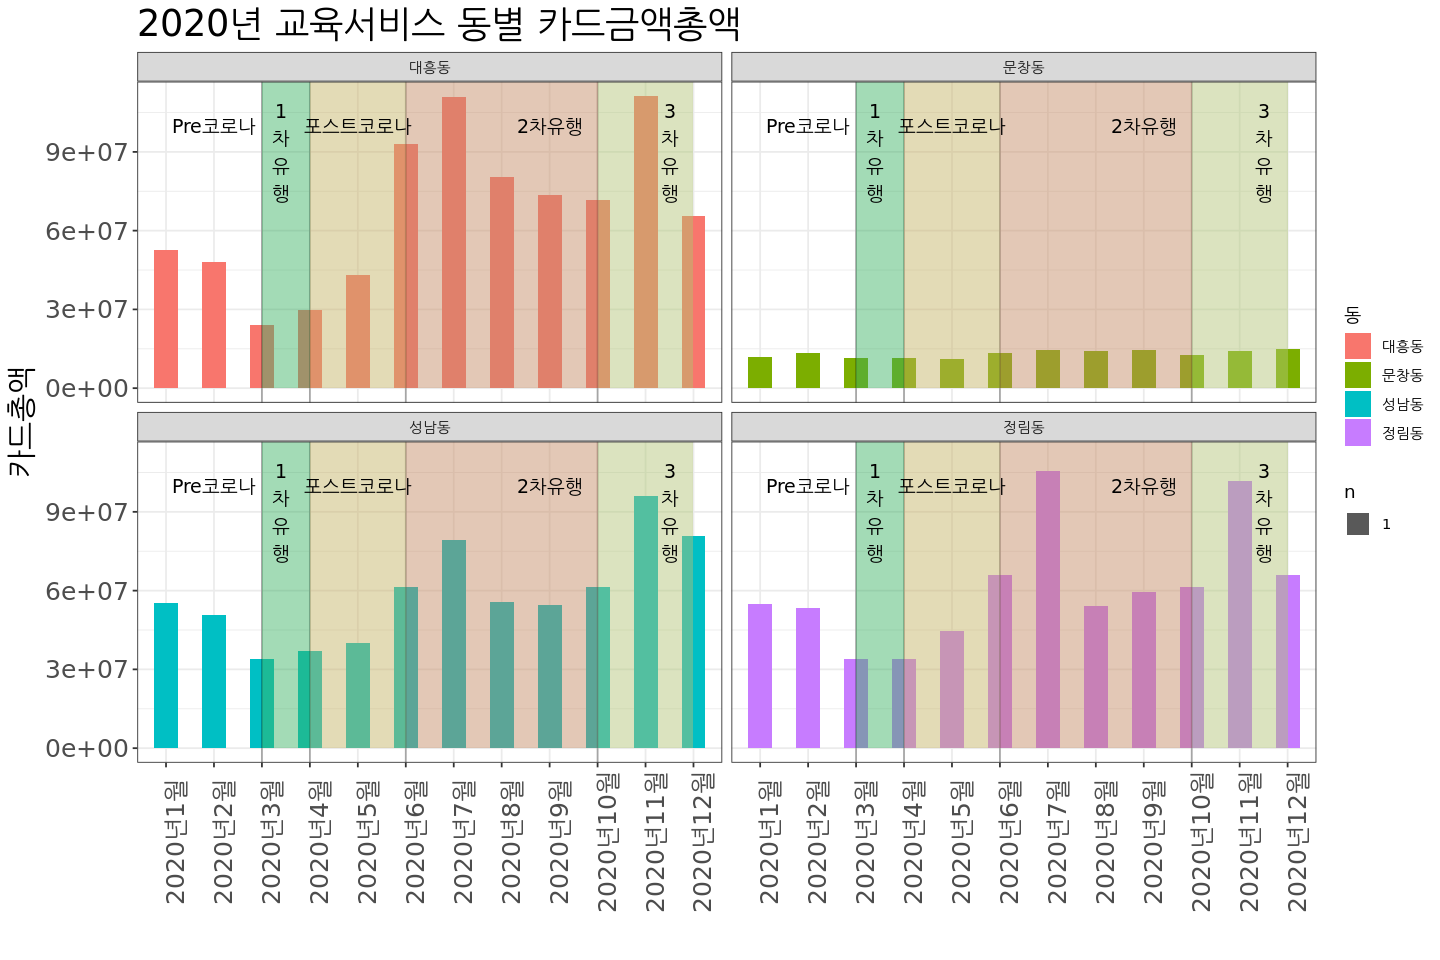

In [9]:
교육$년월=factor(교육$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월','2020년6월','2020년7월','2020년8월',
                            '2020년9월','2020년10월','2020년11월','2020년12월'))

fig(12,8)

ggplot(교육, aes(x=년월,y=교육_서비스업_총액))+
geom_bar(stat="sum", width = 0.5,aes(fill=동))+
geom_vline(aes(xintercept=3),alpha=0.3)+
geom_vline(aes(xintercept=4),alpha=0.3)+
geom_vline(aes(xintercept=6),alpha=0.3)+
geom_vline(aes(xintercept=10),alpha=0.3)+
geom_rect(aes(xmin='2020년3월',xmax='2020년4월',ymin=-0.5,ymax=Inf),fill='#47C262',alpha=0.05)+
geom_rect(aes(xmin='2020년4월',xmax='2020년6월',ymin=-0.5,ymax=Inf),fill='#CCB366',alpha=0.05)+
geom_rect(aes(xmin='2020년6월',xmax='2020년10월',ymin=-0.5,ymax=Inf),fill='#CB9C62',alpha=0.05)+
geom_rect(aes(xmin='2020년10월',xmax='2020년12월',ymin=-0.5,ymax=Inf),fill='#BFD279',alpha=0.05)+
labs(x="",y="카드총액",title="2020년 교육서비스 동별 카드금액총액")+ 
facet_wrap(~동)+ 
geom_text(data=data.frame(x=2,y=100000000,cyl=4,label="Pre코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=3.4,y=90000000,cyl=4,label="1\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=5,y=100000000,cyl=4,label="포스트코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=9,y=100000000,cyl=4,label="2차유행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=11.5,y=90000000,cyl=4,label="3\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
theme_bw()+
theme(plot.title=element_text(size=22),axis.text.x=element_text(size=15,angle=90),
      axis.text.y=element_text(size=15),axis.title=element_text(size=18))

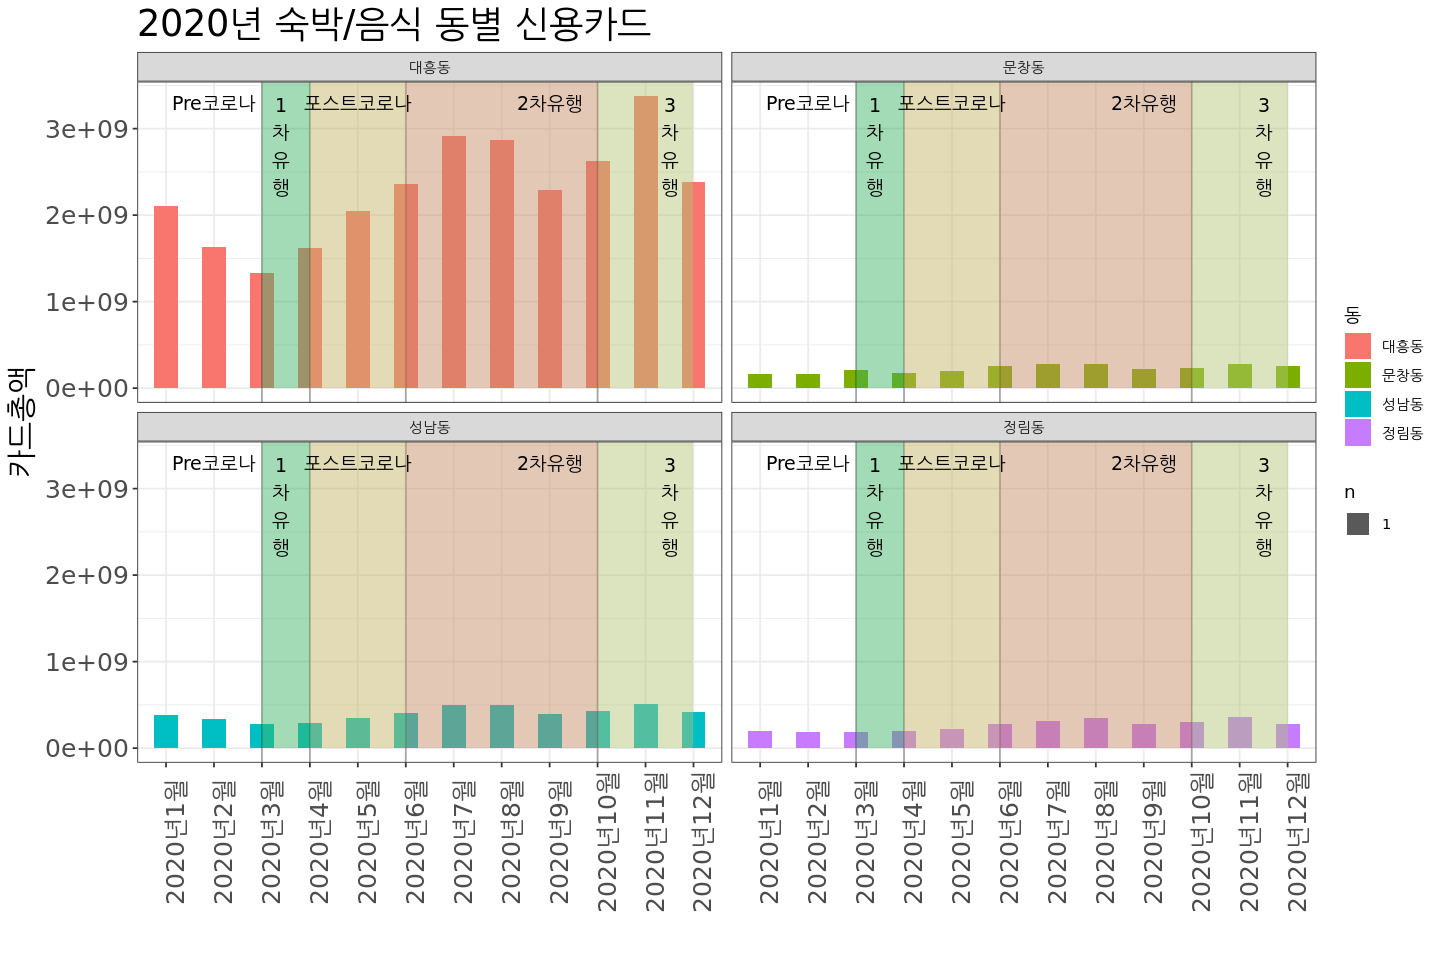

In [10]:
숙박음식$년월=factor(숙박음식$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월','2020년6월','2020년7월','2020년8월',
                            '2020년9월','2020년10월','2020년11월','2020년12월'))

fig(12,8)

ggplot(숙박음식, aes(x=년월,y=숙박_및_음식점업_총액))+
geom_bar(stat="sum", width = 0.5,aes(fill=동))+
geom_vline(aes(xintercept=3),alpha=0.3)+
geom_vline(aes(xintercept=4),alpha=0.3)+
geom_vline(aes(xintercept=6),alpha=0.3)+
geom_vline(aes(xintercept=10),alpha=0.3)+
geom_rect(aes(xmin='2020년3월',xmax='2020년4월',ymin=-0.5,ymax=Inf),fill='#47C262',alpha=0.05)+
geom_rect(aes(xmin='2020년4월',xmax='2020년6월',ymin=-0.5,ymax=Inf),fill='#CCB366',alpha=0.05)+
geom_rect(aes(xmin='2020년6월',xmax='2020년10월',ymin=-0.5,ymax=Inf),fill='#CB9C62',alpha=0.05)+
geom_rect(aes(xmin='2020년10월',xmax='2020년12월',ymin=-0.5,ymax=Inf),fill='#BFD279',alpha=0.05)+
labs(x="",y="카드총액",title="2020년 숙박/음식 동별 신용카드")+ 
facet_wrap(~동)+ 
geom_text(data=data.frame(x=2,y=3300000000,cyl=4,label="Pre코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=3.4,y=2800000000,cyl=4,label="1\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=5,y=3300000000,cyl=4,label="포스트코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=9,y=3300000000,cyl=4,label="2차유행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=11.5,y=2800000000,cyl=4,label="3\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
theme_bw()+
theme(plot.title=element_text(size=22),axis.text.x=element_text(size=15,angle=90),
      axis.text.y=element_text(size=15),axis.title=element_text(size=18))

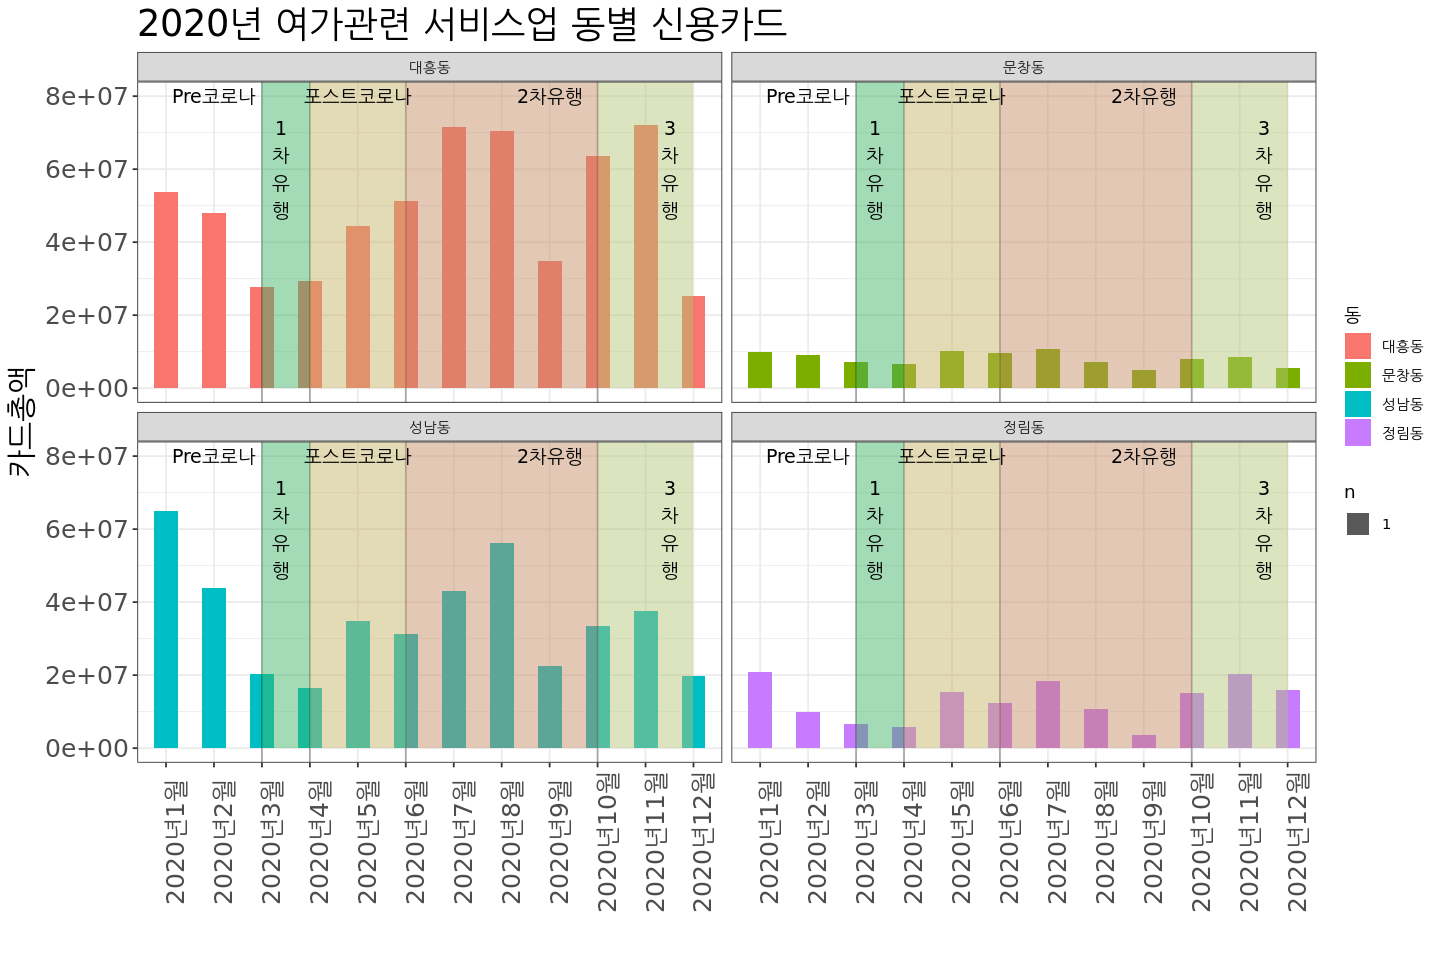

In [11]:
여가$년월=factor(여가$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월','2020년6월','2020년7월','2020년8월',
                            '2020년9월','2020년10월','2020년11월','2020년12월'))

fig(12,8)

ggplot(여가, aes(x=년월,y=예술_스포츠_및_여가관련_서비스업_총액))+
geom_bar(stat="sum", width = 0.5,aes(fill=동))+
geom_vline(aes(xintercept=3),alpha=0.3)+
geom_vline(aes(xintercept=4),alpha=0.3)+
geom_vline(aes(xintercept=6),alpha=0.3)+
geom_vline(aes(xintercept=10),alpha=0.3)+
geom_rect(aes(xmin='2020년3월',xmax='2020년4월',ymin=-0.5,ymax=Inf),fill='#47C262',alpha=0.05)+
geom_rect(aes(xmin='2020년4월',xmax='2020년6월',ymin=-0.5,ymax=Inf),fill='#CCB366',alpha=0.05)+
geom_rect(aes(xmin='2020년6월',xmax='2020년10월',ymin=-0.5,ymax=Inf),fill='#CB9C62',alpha=0.05)+
geom_rect(aes(xmin='2020년10월',xmax='2020년12월',ymin=-0.5,ymax=Inf),fill='#BFD279',alpha=0.05)+
labs(x="",y="카드총액",title="2020년 여가관련 서비스업 동별 신용카드")+ 
facet_wrap(~동)+ 
geom_text(data=data.frame(x=2,y=80000000,cyl=4,label="Pre코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=3.4,y=60000000,cyl=4,label="1\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=5,y=80000000,cyl=4,label="포스트코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=9,y=80000000,cyl=4,label="2차유행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=11.5,y=60000000,cyl=4,label="3\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
theme_bw()+
theme(plot.title=element_text(size=22),axis.text.x=element_text(size=15,angle=90),
      axis.text.y=element_text(size=15),axis.title=element_text(size=18))

Warning message:
“Removed 20 rows containing non-finite values (stat_sum).”


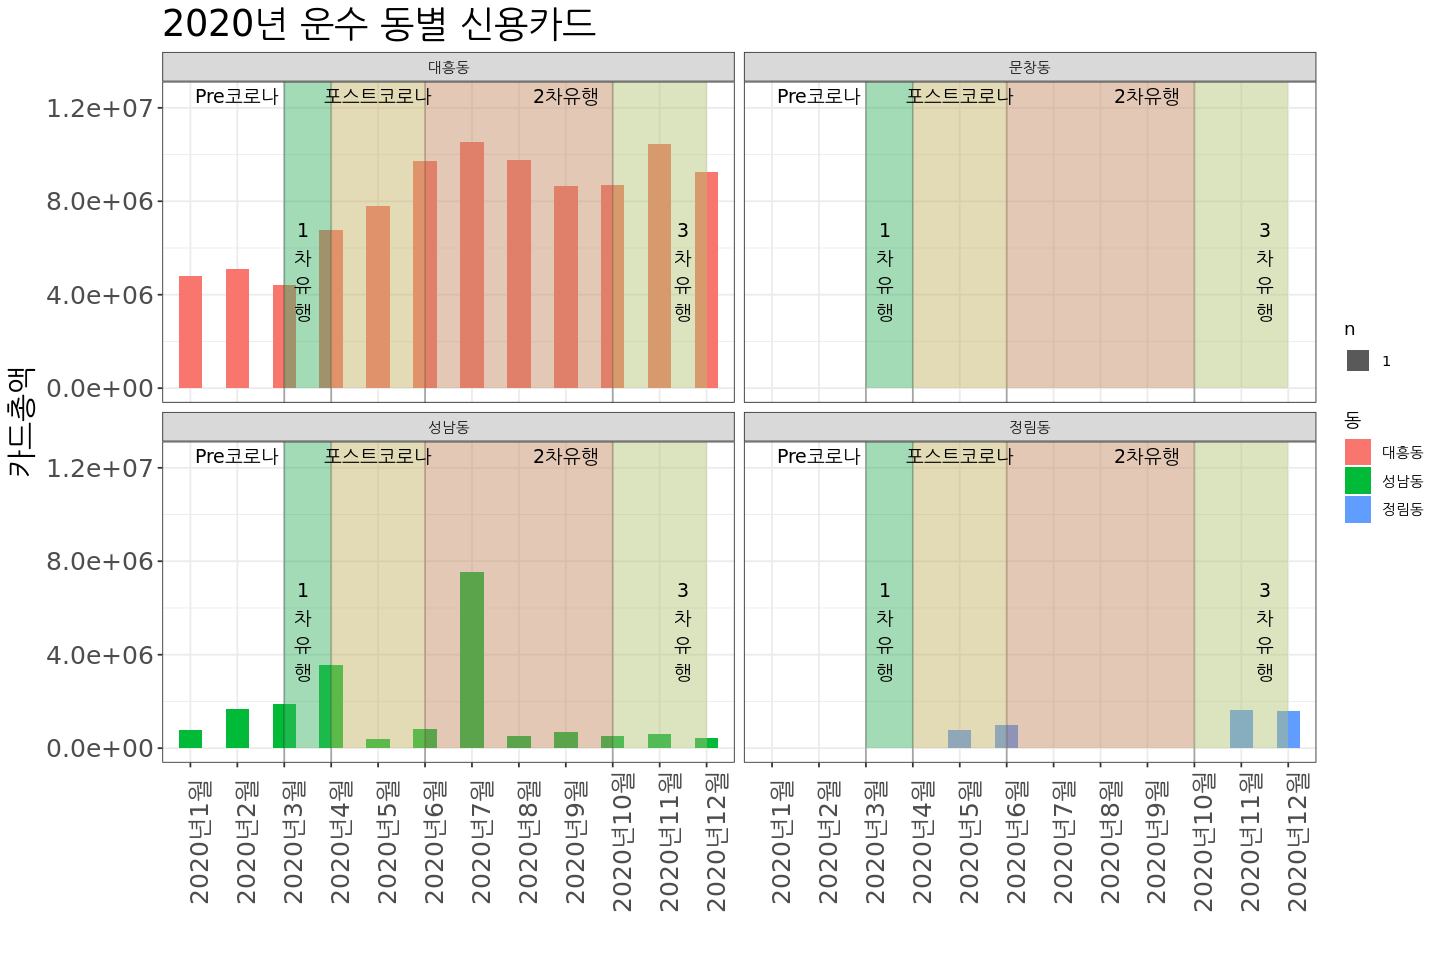

In [12]:
운수$년월=factor(운수$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월','2020년6월','2020년7월','2020년8월',
                            '2020년9월','2020년10월','2020년11월','2020년12월'))

fig(12,8)

ggplot(운수, aes(x=년월,y=운수_및_창고업_총액))+
geom_bar(stat="sum", width = 0.5,aes(fill=동))+
geom_vline(aes(xintercept=3),alpha=0.3)+
geom_vline(aes(xintercept=4),alpha=0.3)+
geom_vline(aes(xintercept=6),alpha=0.3)+
geom_vline(aes(xintercept=10),alpha=0.3)+
geom_rect(aes(xmin='2020년3월',xmax='2020년4월',ymin=-0.5,ymax=Inf),fill='#47C262',alpha=0.05)+
geom_rect(aes(xmin='2020년4월',xmax='2020년6월',ymin=-0.5,ymax=Inf),fill='#CCB366',alpha=0.05)+
geom_rect(aes(xmin='2020년6월',xmax='2020년10월',ymin=-0.5,ymax=Inf),fill='#CB9C62',alpha=0.05)+
geom_rect(aes(xmin='2020년10월',xmax='2020년12월',ymin=-0.5,ymax=Inf),fill='#BFD279',alpha=0.05)+
labs(x="",y="카드총액",title="2020년 운수 동별 신용카드")+ 
facet_wrap(~동)+ 
geom_text(data=data.frame(x=2,y=12500000,cyl=4,label="Pre코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=3.4,y=5000000,cyl=4,label="1\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=5,y=12500000,cyl=4,label="포스트코로나"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=9,y=12500000,cyl=4,label="2차유행"), 
          aes(x=x,y=y,label=label),size=4)+
geom_text(data=data.frame(x=11.5,y=5000000,cyl=4,label="3\n차\n유\n행"), 
          aes(x=x,y=y,label=label),size=4)+
theme_bw()+
theme(plot.title=element_text(size=22),axis.text.x=element_text(size=15,angle=90),
      axis.text.y=element_text(size=15),axis.title=element_text(size=18))

In [13]:
pre_mask=(교육$년월=='2020년1월'|교육$년월=='2020년2월'|교육$년월=='2020년3월')
one_mask=(교육$년월=='2020년3월'|교육$년월=='2020년4월')
post_mask=(교육$년월=='2020년4월'|교육$년월=='2020년5월'|교육$년월=='2020년6월')
two_mask=(교육$년월=='2020년6월'|교육$년월=='2020년7월'|교육$년월=='2020년8월'|교육$년월=='2020년9월'|교육$년월=='2020년10월')
three_mask=(교육$년월=='2020년10월'|교육$년월=='2020년11월'|교육$년월=='2020년12월')

pre교육=교육[pre_mask,] %>% group_by(동) %>%
summarise(mean = mean(교육_서비스업_총액),.groups='drop')
one교육=교육[one_mask,] %>% group_by(동) %>%
summarise(mean = mean(교육_서비스업_총액),.groups='drop')
post교육=교육[post_mask,] %>% group_by(동) %>%
summarise(mean = mean(교육_서비스업_총액),.groups='drop')
two교육=교육[two_mask,] %>% group_by(동) %>%
summarise(mean = mean(교육_서비스업_총액),.groups='drop')
three교육=교육[three_mask,] %>% group_by(동) %>%
summarise(mean = mean(교육_서비스업_총액),.groups='drop')

기간별교육=merge(pre교육,one교육,by='동') %>% merge(post교육,by='동') %>% merge(two교육,by='동') %>% merge(three교육,by='동')
names(기간별교육)=c('동','pre코로나','1차유행','포스트코로나','2차유행','3차유행')

기간별교육$preTOone=apply(기간별교육,1,function(x) as.numeric(x['1차유행'])/as.numeric(x['pre코로나'])*100)
기간별교육$oneTOpost=apply(기간별교육,1,function(x) as.numeric(x['포스트코로나'])/as.numeric(x['1차유행'])*100)
기간별교육$postTOtwo=apply(기간별교육,1,function(x) as.numeric(x['2차유행'])/as.numeric(x['포스트코로나'])*100)
기간별교육$twoTOthree=apply(기간별교육,1,function(x) as.numeric(x['3차유행'])/as.numeric(x['2차유행'])*100)

Warning message in merge.data.frame(., two교육, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”
Warning message in merge.data.frame(., three교육, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”


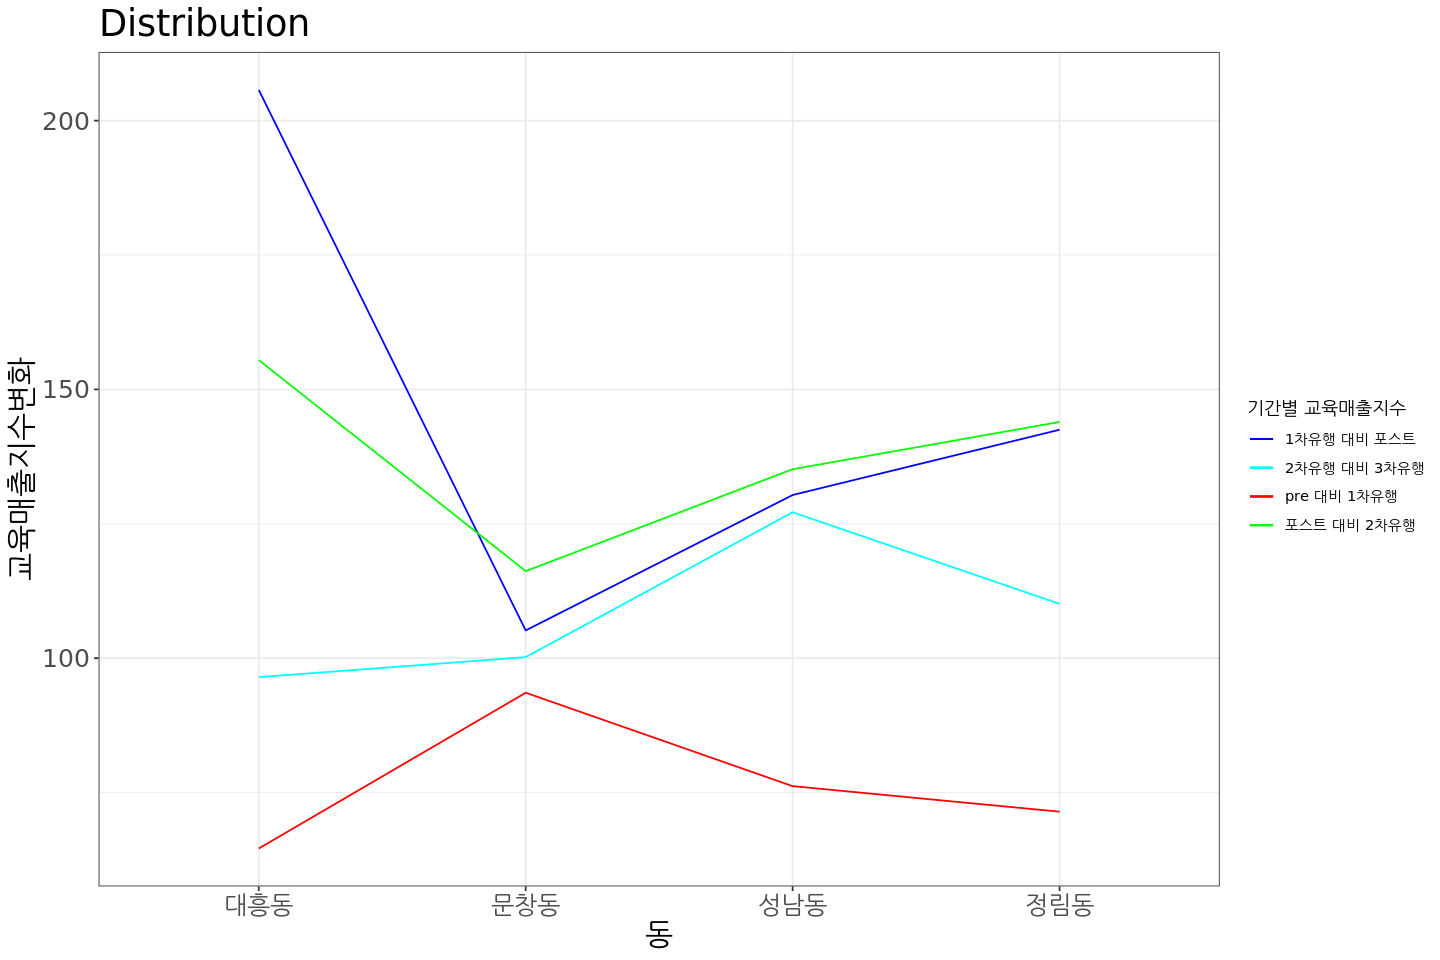

In [14]:
fig(12,8)
cols=c("pre 대비 1차유행"="red","1차유행 대비 포스트"="blue","포스트 대비 2차유행"="green","2차유행 대비 3차유행"="cyan")

ggplot(기간별교육) + 
geom_line(aes(x=c(1,2,3,4),y=preTOone,colour='pre 대비 1차유행')) + 
geom_line(aes(x=c(1,2,3,4),y=oneTOpost,colour='1차유행 대비 포스트')) +
geom_line(aes(x=c(1,2,3,4),y=postTOtwo,colour='포스트 대비 2차유행')) +
geom_line(aes(x=c(1,2,3,4),y=twoTOthree,colour='2차유행 대비 3차유행')) +
scale_x_discrete(limit = c("대흥동","문창동","성남동","정림동"))+
scale_colour_manual(values = cols) +
labs(x="동",
         y="교육매출지수변화",
     colour='기간별 교육매출지수',
       title="Distribution")+ 
theme_bw()+
theme(plot.title = element_text(size=22)
      ,axis.text.x= element_text(size=15),
       axis.text.y= element_text(size=15),
        axis.title=element_text(size=18))

In [16]:
pre_mask=(여가$년월=='2020년1월'|여가$년월=='2020년2월'|여가$년월=='2020년3월')
one_mask=(여가$년월=='2020년3월'|여가$년월=='2020년4월')
post_mask=(여가$년월=='2020년4월'|여가$년월=='2020년5월'|여가$년월=='2020년6월')
two_mask=(여가$년월=='2020년6월'|여가$년월=='2020년7월'|여가$년월=='2020년8월'|여가$년월=='2020년9월'|여가$년월=='2020년10월')
three_mask=(여가$년월=='2020년10월'|여가$년월=='2020년11월'|여가$년월=='2020년12월')

pre여가=여가[pre_mask,] %>% group_by(동) %>%
summarise(mean = mean(예술_스포츠_및_여가관련_서비스업_총액),.groups='drop')
one여가=여가[one_mask,] %>% group_by(동) %>%
summarise(mean = mean(예술_스포츠_및_여가관련_서비스업_총액),.groups='drop')
post여가=여가[post_mask,] %>% group_by(동) %>%
summarise(mean = mean(예술_스포츠_및_여가관련_서비스업_총액),.groups='drop')
two여가=여가[two_mask,] %>% group_by(동) %>%
summarise(mean = mean(예술_스포츠_및_여가관련_서비스업_총액),.groups='drop')
three여가=여가[three_mask,] %>% group_by(동) %>%
summarise(mean = mean(예술_스포츠_및_여가관련_서비스업_총액),.groups='drop')

기간별여가=merge(pre여가,one여가,by='동') %>% merge(post여가,by='동') %>% merge(two여가,by='동') %>% merge(three여가,by='동')
names(기간별여가)=c('동','pre코로나','1차유행','포스트코로나','2차유행','3차유행')

기간별여가$preTOone=apply(기간별여가,1,function(x) as.numeric(x['1차유행'])/as.numeric(x['pre코로나'])*100)
기간별여가$oneTOpost=apply(기간별여가,1,function(x) as.numeric(x['포스트코로나'])/as.numeric(x['1차유행'])*100)
기간별여가$postTOtwo=apply(기간별여가,1,function(x) as.numeric(x['2차유행'])/as.numeric(x['포스트코로나'])*100)
기간별여가$twoTOthree=apply(기간별여가,1,function(x) as.numeric(x['3차유행'])/as.numeric(x['2차유행'])*100)

Warning message in merge.data.frame(., two여가, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”
Warning message in merge.data.frame(., three여가, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”


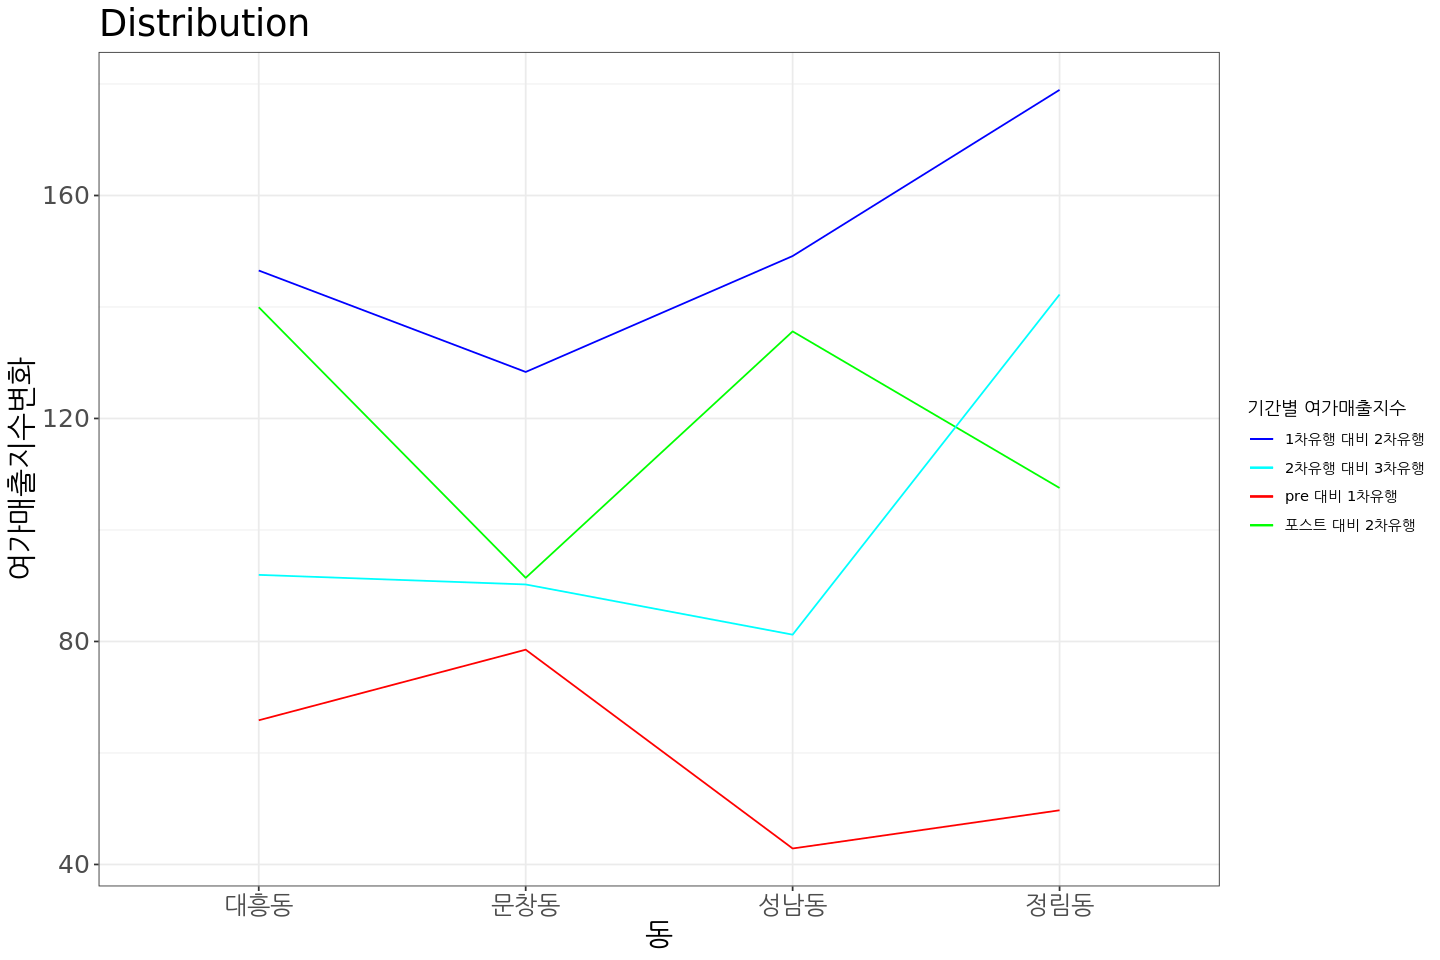

In [17]:
fig(12,8)
cols=c("pre 대비 1차유행"="red","1차유행 대비 2차유행"="blue","포스트 대비 2차유행"="green","2차유행 대비 3차유행"="cyan")

ggplot(기간별여가) + 
geom_line(aes(x=c(1,2,3,4),y=preTOone,colour='pre 대비 1차유행')) + 
geom_line(aes(x=c(1,2,3,4),y=oneTOpost,colour='1차유행 대비 2차유행')) +
geom_line(aes(x=c(1,2,3,4),y=postTOtwo,colour='포스트 대비 2차유행')) +
geom_line(aes(x=c(1,2,3,4),y=twoTOthree,colour='2차유행 대비 3차유행')) +
scale_x_discrete(limit = c("대흥동","문창동","성남동","정림동"))+
scale_colour_manual(values = cols) +
labs(x="동",
         y="여가매출지수변화",
     colour='기간별 여가매출지수',
       title="Distribution")+ 
theme_bw()+
theme(plot.title = element_text(size=22)
      ,axis.text.x= element_text(size=15),
       axis.text.y= element_text(size=15),
        axis.title=element_text(size=18))

In [18]:
pre_mask=(운수$년월=='2020년1월'|운수$년월=='2020년2월'|운수$년월=='2020년3월')
one_mask=(운수$년월=='2020년3월'|운수$년월=='2020년4월')
post_mask=(운수$년월=='2020년4월'|운수$년월=='2020년5월'|운수$년월=='2020년6월')
two_mask=(운수$년월=='2020년6월'|운수$년월=='2020년7월'|운수$년월=='2020년8월'|운수$년월=='2020년9월'|운수$년월=='2020년10월')
three_mask=(운수$년월=='2020년10월'|운수$년월=='2020년11월'|운수$년월=='2020년12월')

pre운수=운수[pre_mask,] %>% group_by(동) %>%
summarise(mean = mean(운수_및_창고업_총액),.groups='drop')
one운수=운수[one_mask,] %>% group_by(동) %>%
summarise(mean = mean(운수_및_창고업_총액),.groups='drop')
post운수=운수[post_mask,] %>% group_by(동) %>%
summarise(mean = mean(운수_및_창고업_총액),.groups='drop')
two운수=운수[two_mask,] %>% group_by(동) %>%
summarise(mean = mean(운수_및_창고업_총액),.groups='drop')
three운수=운수[three_mask,] %>% group_by(동) %>%
summarise(mean = mean(운수_및_창고업_총액),.groups='drop')

기간별운수=merge(pre운수,one운수,by='동') %>% merge(post운수,by='동') %>% merge(two운수,by='동') %>% merge(three운수,by='동')
names(기간별운수)=c('동','pre코로나','1차유행','포스트코로나','2차유행','3차유행')

# apply(기간별교육,1,function(x) as.numeric(x['pre코로나']))
기간별운수$preTOone=apply(기간별운수,1,function(x) as.numeric(x['1차유행'])/as.numeric(x['pre코로나'])*100)
기간별운수$oneTOpost=apply(기간별운수,1,function(x) as.numeric(x['포스트코로나'])/as.numeric(x['1차유행'])*100)
기간별운수$postTOtwo=apply(기간별운수,1,function(x) as.numeric(x['2차유행'])/as.numeric(x['포스트코로나'])*100)
기간별운수$twoTOthree=apply(기간별운수,1,function(x) as.numeric(x['3차유행'])/as.numeric(x['2차유행'])*100)

Warning message in merge.data.frame(., two운수, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”
Warning message in merge.data.frame(., three운수, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”


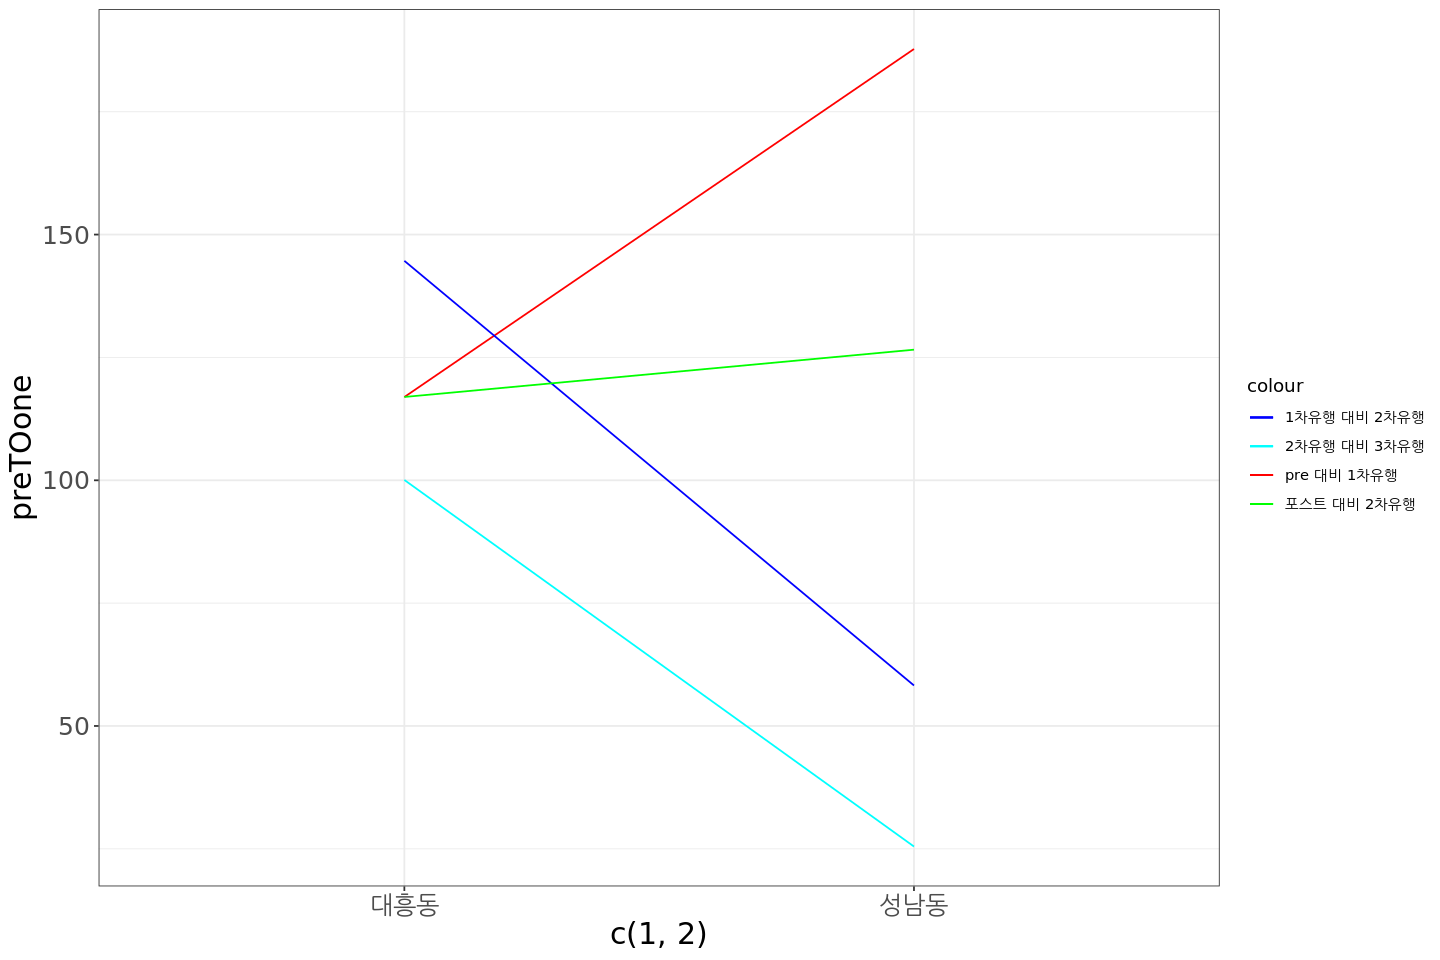

In [19]:
fig(12,8)
cols=c("pre 대비 1차유행"="red","1차유행 대비 2차유행"="blue","포스트 대비 2차유행"="green","2차유행 대비 3차유행"="cyan")

ggplot(기간별운수[c(1,3),]) + 
geom_line(aes(x=c(1,2),y=preTOone,colour='pre 대비 1차유행')) + 
geom_line(aes(x=c(1,2),y=oneTOpost,colour='1차유행 대비 2차유행')) +
geom_line(aes(x=c(1,2),y=postTOtwo,colour='포스트 대비 2차유행')) +
geom_line(aes(x=c(1,2),y=twoTOthree,colour='2차유행 대비 3차유행')) +
scale_x_discrete(limit = c("대흥동","성남동"))+
scale_colour_manual(values = cols) +
theme_bw()+
theme(plot.title = element_text(size=22)
      ,axis.text.x= element_text(size=15),
       axis.text.y= element_text(size=15),
        axis.title=element_text(size=18))

In [20]:
# 교육,금융,기타,도소매,사회복지,숙박음식,부동산,사업지원,여가,운수,과학기술,정보통신,제조업,협회

pre_mask=(숙박음식$년월=='2020년1월'|숙박음식$년월=='2020년2월'|숙박음식$년월=='2020년3월')
one_mask=(숙박음식$년월=='2020년3월'|숙박음식$년월=='2020년4월')
post_mask=(숙박음식$년월=='2020년4월'|숙박음식$년월=='2020년5월'|숙박음식$년월=='2020년6월')
two_mask=(숙박음식$년월=='2020년6월'|숙박음식$년월=='2020년7월'|숙박음식$년월=='2020년8월'|숙박음식$년월=='2020년9월'|숙박음식$년월=='2020년10월')
three_mask=(숙박음식$년월=='2020년10월'|숙박음식$년월=='2020년11월'|숙박음식$년월=='2020년12월')

pre숙박음식=숙박음식[pre_mask,] %>% group_by(동) %>%
summarise(mean = mean(숙박_및_음식점업_총액),.groups='drop')
one숙박음식=숙박음식[one_mask,] %>% group_by(동) %>%
summarise(mean = mean(숙박_및_음식점업_총액),.groups='drop')
post숙박음식=숙박음식[post_mask,] %>% group_by(동) %>%
summarise(mean = mean(숙박_및_음식점업_총액),.groups='drop')
two숙박음식=숙박음식[two_mask,] %>% group_by(동) %>%
summarise(mean = mean(숙박_및_음식점업_총액),.groups='drop')
three숙박음식=숙박음식[three_mask,] %>% group_by(동) %>%
summarise(mean = mean(숙박_및_음식점업_총액),.groups='drop')

기간별숙박음식=merge(pre숙박음식,one숙박음식,by='동') %>% merge(post숙박음식,by='동') %>% merge(two숙박음식,by='동') %>% merge(three숙박음식,by='동')
names(기간별숙박음식)=c('동','pre코로나','1차유행','포스트코로나','2차유행','3차유행')

기간별숙박음식$preTOone=apply(기간별숙박음식,1,function(x) as.numeric(x['1차유행'])/as.numeric(x['pre코로나'])*100)
기간별숙박음식$oneTOpost=apply(기간별숙박음식,1,function(x) as.numeric(x['포스트코로나'])/as.numeric(x['1차유행'])*100)
기간별숙박음식$postTOtwo=apply(기간별숙박음식,1,function(x) as.numeric(x['2차유행'])/as.numeric(x['포스트코로나'])*100)
기간별숙박음식$twoTOthree=apply(기간별숙박음식,1,function(x) as.numeric(x['3차유행'])/as.numeric(x['2차유행'])*100)

Warning message in merge.data.frame(., two숙박음식, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”
Warning message in merge.data.frame(., three숙박음식, by = "동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”


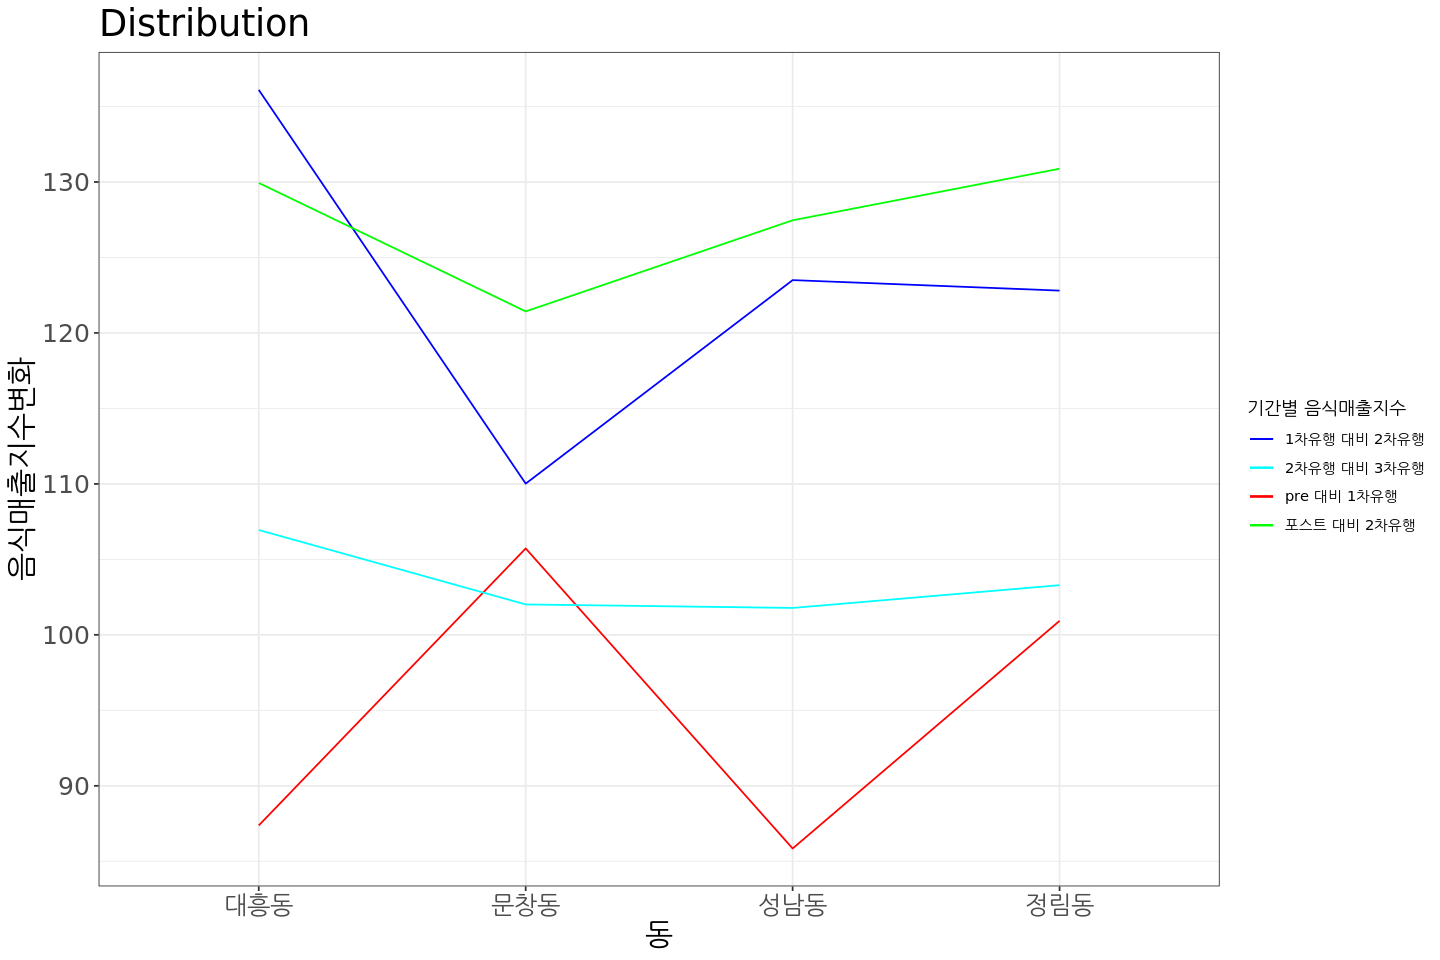

In [21]:
fig(12,8)
cols=c("pre 대비 1차유행"="red","1차유행 대비 2차유행"="blue","포스트 대비 2차유행"="green","2차유행 대비 3차유행"="cyan")

ggplot(기간별숙박음식) + 
geom_line(aes(x=c(1,2,3,4),y=preTOone,colour='pre 대비 1차유행')) + 
geom_line(aes(x=c(1,2,3,4),y=oneTOpost,colour='1차유행 대비 2차유행')) +
geom_line(aes(x=c(1,2,3,4),y=postTOtwo,colour='포스트 대비 2차유행')) +
geom_line(aes(x=c(1,2,3,4),y=twoTOthree,colour='2차유행 대비 3차유행')) +
scale_x_discrete(limit = c("대흥동","문창동","성남동","정림동"))+
scale_colour_manual(values = cols) +
labs(x="동",
         y="음식매출지수변화",
     colour='기간별 음식매출지수',
       title="Distribution")+ 
theme_bw()+
theme(plot.title = element_text(size=22)
      ,axis.text.x= element_text(size=15),
       axis.text.y= element_text(size=15),
        axis.title=element_text(size=18))

In [22]:
pre_mask=(유동인구$연월=='202001'|유동인구$연월=='202002'|유동인구$연월=='202003')
one_mask=(유동인구$연월=='202003'|유동인구$연월=='202004')
post_mask=(유동인구$연월=='202004'|유동인구$연월=='202005'|유동인구$연월=='202006')
two_mask=(유동인구$연월=='202006'|유동인구$연월=='202007'|유동인구$연월=='202008'|유동인구$연월=='202009'|유동인구$연월=='202010')
three_mask=(유동인구$연월=='202010'|유동인구$연월=='202011'|유동인구$연월=='202012')

pre유동인구=유동인구[pre_mask,] %>% group_by(행정동) %>%
summarise(mean = mean(총합),.groups='drop')
one유동인구=유동인구[one_mask,] %>% group_by(행정동) %>%
summarise(mean = mean(총합),.groups='drop')
post유동인구=유동인구[post_mask,] %>% group_by(행정동) %>%
summarise(mean = mean(총합),.groups='drop')
two유동인구=유동인구[two_mask,] %>% group_by(행정동) %>%
summarise(mean = mean(총합),.groups='drop')
three유동인구=유동인구[three_mask,] %>% group_by(행정동) %>%
summarise(mean = mean(총합),.groups='drop')

기간별유동인구=merge(pre유동인구,one유동인구,by='행정동') %>% merge(post유동인구,by='행정동') %>% merge(two유동인구,by='행정동') %>% merge(three유동인구,by='행정동')
names(기간별유동인구)=c('동','pre코로나','1차유행','포스트코로나','2차유행','3차유행')

기간별유동인구$preTOone=apply(기간별유동인구,1,function(x) as.numeric(x['1차유행'])/as.numeric(x['pre코로나'])*100)
기간별유동인구$oneTOpost=apply(기간별유동인구,1,function(x) as.numeric(x['포스트코로나'])/as.numeric(x['1차유행'])*100)
기간별유동인구$postTOtwo=apply(기간별유동인구,1,function(x) as.numeric(x['2차유행'])/as.numeric(x['포스트코로나'])*100)
기간별유동인구$twoTOthree=apply(기간별유동인구,1,function(x) as.numeric(x['3차유행'])/as.numeric(x['2차유행'])*100)

Warning message in merge.data.frame(., two유동인구, by = "행정동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”
Warning message in merge.data.frame(., three유동인구, by = "행정동"):
“column names ‘mean.x’, ‘mean.y’ are duplicated in the result”


In [23]:
기간별유동인구$백신이후유동인구=lapply(기간별유동인구$twoTOthree,function(x) x>exp(mean(log(기간별유동인구$twoTOthree))))
기간별숙박음식$백신이후음식=lapply(기간별숙박음식$twoTOthree,function(x) x>exp(mean(log(기간별숙박음식$twoTOthree))))
기간별교육$백신이후교육=lapply(기간별교육$twoTOthree,function(x) x>exp(mean(log(기간별교육$twoTOthree))))
기간별여가$백신이후여가=lapply(기간별여가$twoTOthree,function(x) x>exp(mean(log(기간별여가$twoTOthree))))
기간별운수$백신이후운수=lapply(기간별운수$twoTOthree,function(x) x>exp(mean(log(기간별운수$twoTOthree),na.rm=T)))

In [24]:
result=as.data.frame(cbind(기간별유동인구[,11],
                           기간별숙박음식[,11],
                           기간별교육[,11],
                           기간별여가[,11],
                           기간별운수[,11]))
## 4개동 기준 이상인지 이하인지.
colnames(result)=c('유동인구','음식','교육','여가','운수')
rownames(result)=c('대흥동','문창동','성남동','정림동')

In [25]:
result

,유동인구,음식,교육,여가,운수
,<list>,<list>,<list>,<list>,<list>
대흥동,TRUE,TRUE,FALSE,FALSE,TRUE
문창동,TRUE,FALSE,FALSE,FALSE,NA
성남동,FALSE,FALSE,TRUE,FALSE,FALSE
정림동,FALSE,FALSE,TRUE,TRUE,NA


In [26]:
mask=(card$동=='대흥동')

교육=card[mask,c(1,3,8,9,10,11)]
금융=card[mask,c(1,3,12,13,14,15)]
기타=card[mask,c(1,3,16,17,18,19)]
도소매=card[mask,c(1,3,20,21,22,23)]
사회복지=card[mask,c(1,3,24,25,26,27)]
부동산=card[mask,c(1,3,28,29,30,31)]
사업지원=card[mask,c(1,3,32,33,34,35)]
숙박음식=card[mask,c(1,3,36,37,38,39)]
여가=card[mask,c(1,3,40,41,42,43)]
운수=card[mask,c(1,3,44,45,46,47)]
과학기술=card[mask,c(1,3,48,49,50,51)]
정보통신=card[mask,c(1,3,52,53,54,55)]
제조업=card[mask,c(1,3,56,57,58,59)]
협회=card[mask,c(1,3,60,61,62,63)]

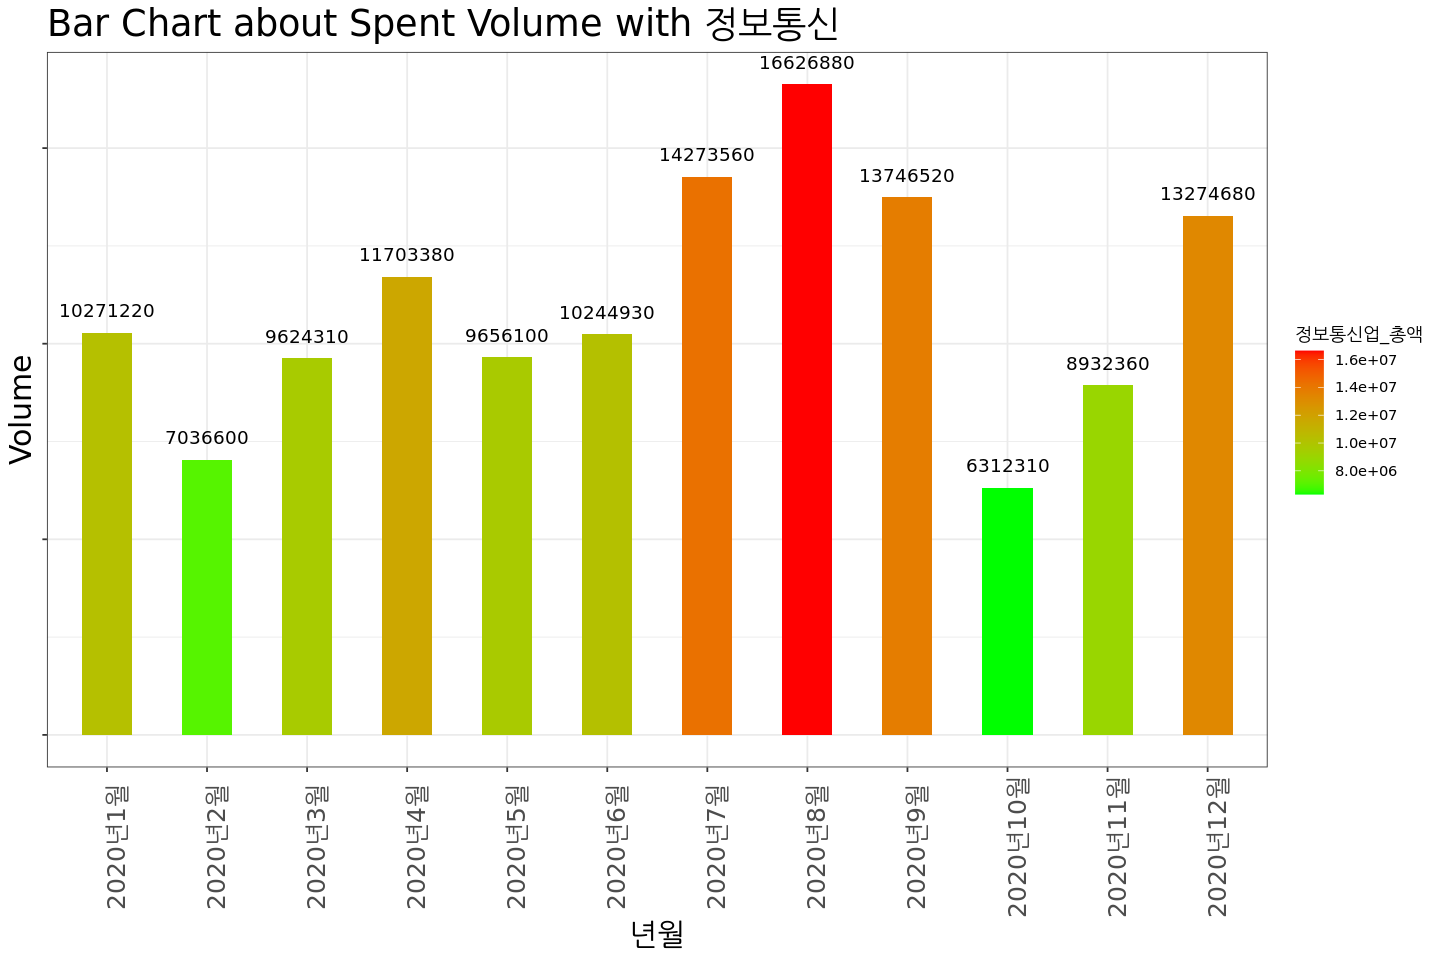

In [27]:
fig(12,8)
정보통신$년월=factor(정보통신$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(정보통신, aes(년월,정보통신업_총액,fill=정보통신업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=정보통신업_총액),vjust=-1.2) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 정보통신")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_blank(), axis.title=element_text(size=18))

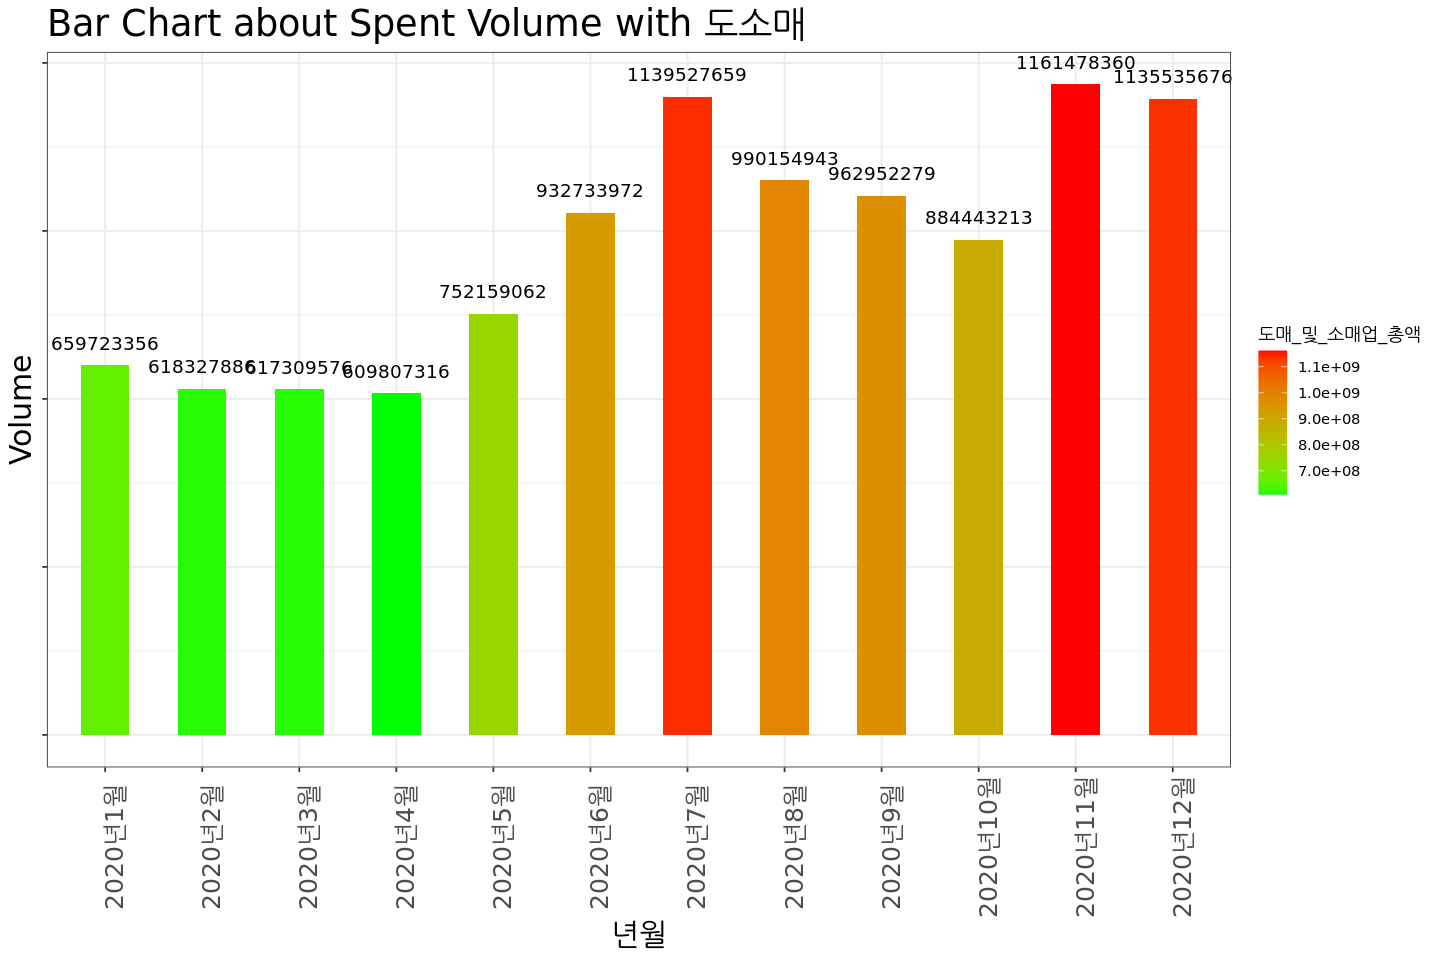

In [28]:
fig(12,8)
도소매$년월=factor(도소매$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(도소매, aes(년월,도매_및_소매업_총액,fill=도매_및_소매업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=도매_및_소매업_총액),vjust=-1.2) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 도소매")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_blank(), axis.title=element_text(size=18))

In [29]:
# mask=(card$동=='성남동'|card$동=='정림동'|card$동=='문창동'|card$동=='대흥동')

mask=(card$동=='성남동')

교육=card[mask,c(1,3,8,9,10,11)]
금융=card[mask,c(1,3,12,13,14,15)]
기타=card[mask,c(1,3,16,17,18,19)]
도소매=card[mask,c(1,3,20,21,22,23)]
사회복지=card[mask,c(1,3,24,25,26,27)]
부동산=card[mask,c(1,3,28,29,30,31)]
사업지원=card[mask,c(1,3,32,33,34,35)]
숙박음식=card[mask,c(1,3,36,37,38,39)]
여가=card[mask,c(1,3,40,41,42,43)]
운수=card[mask,c(1,3,44,45,46,47)]
과학기술=card[mask,c(1,3,48,49,50,51)]
정보통신=card[mask,c(1,3,52,53,54,55)]
제조업=card[mask,c(1,3,56,57,58,59)]
협회=card[mask,c(1,3,60,61,62,63)]

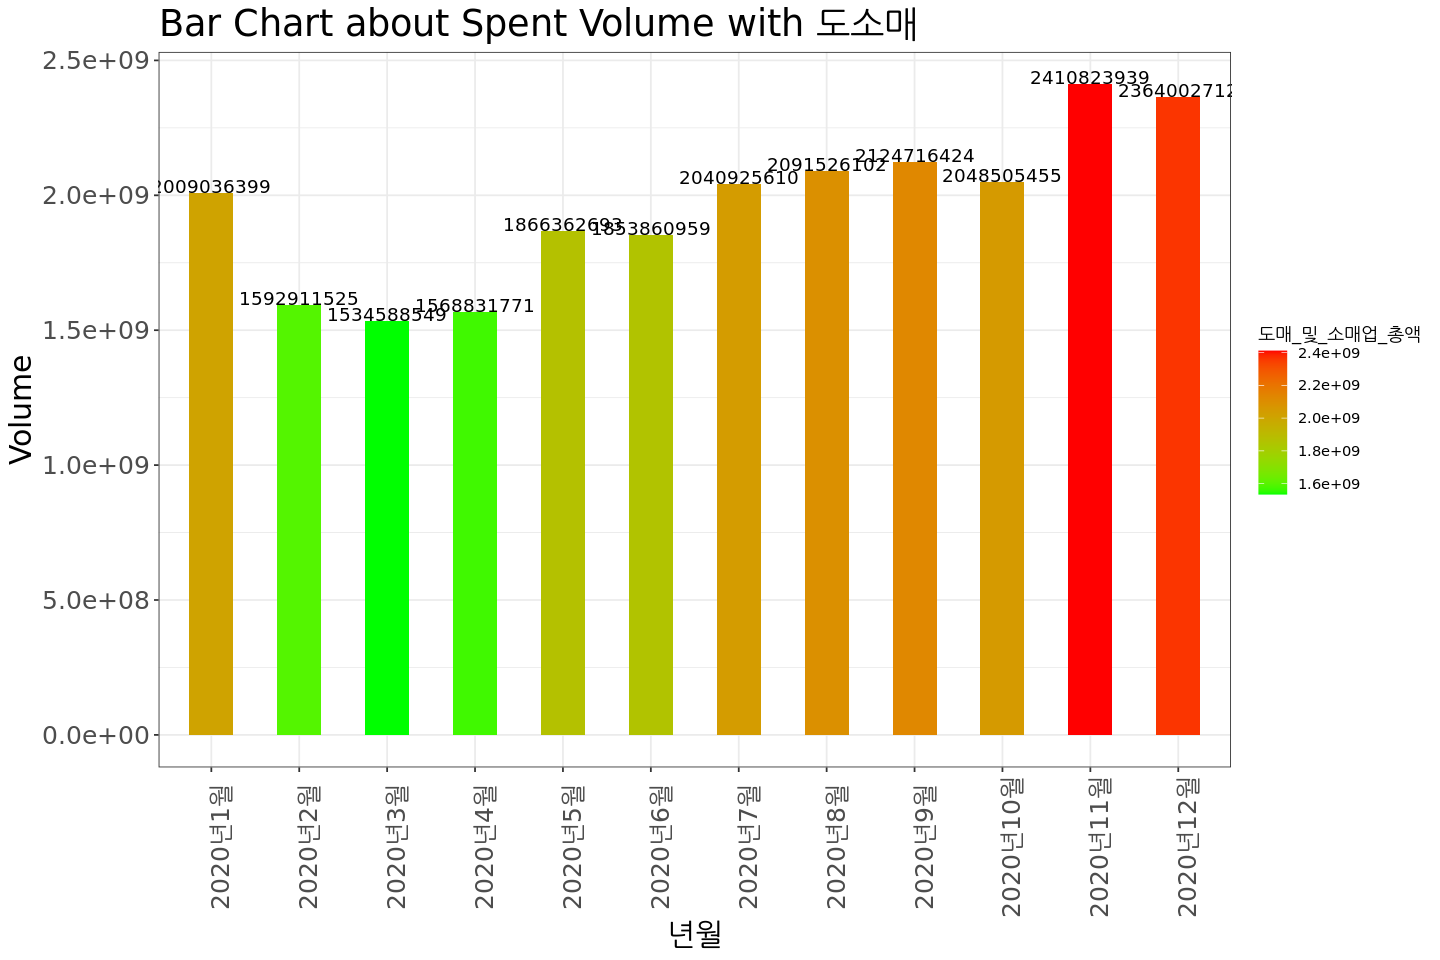

In [30]:
fig(12,8)
도소매$년월=factor(도소매$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(도소매, aes(년월,도매_및_소매업_총액,fill=도매_및_소매업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=도매_및_소매업_총액),vjust=0) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 도소매")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_text(size=15), axis.title=element_text(size=18))

In [31]:
mask=(card$동=='문창동')

교육=card[mask,c(1,3,8,9,10,11)]
금융=card[mask,c(1,3,12,13,14,15)]
기타=card[mask,c(1,3,16,17,18,19)]
도소매=card[mask,c(1,3,20,21,22,23)]
사회복지=card[mask,c(1,3,24,25,26,27)]
부동산=card[mask,c(1,3,28,29,30,31)]
사업지원=card[mask,c(1,3,32,33,34,35)]
숙박음식=card[mask,c(1,3,36,37,38,39)]
여가=card[mask,c(1,3,40,41,42,43)]
운수=card[mask,c(1,3,44,45,46,47)]
과학기술=card[mask,c(1,3,48,49,50,51)]
정보통신=card[mask,c(1,3,52,53,54,55)]
제조업=card[mask,c(1,3,56,57,58,59)]
협회=card[mask,c(1,3,60,61,62,63)]

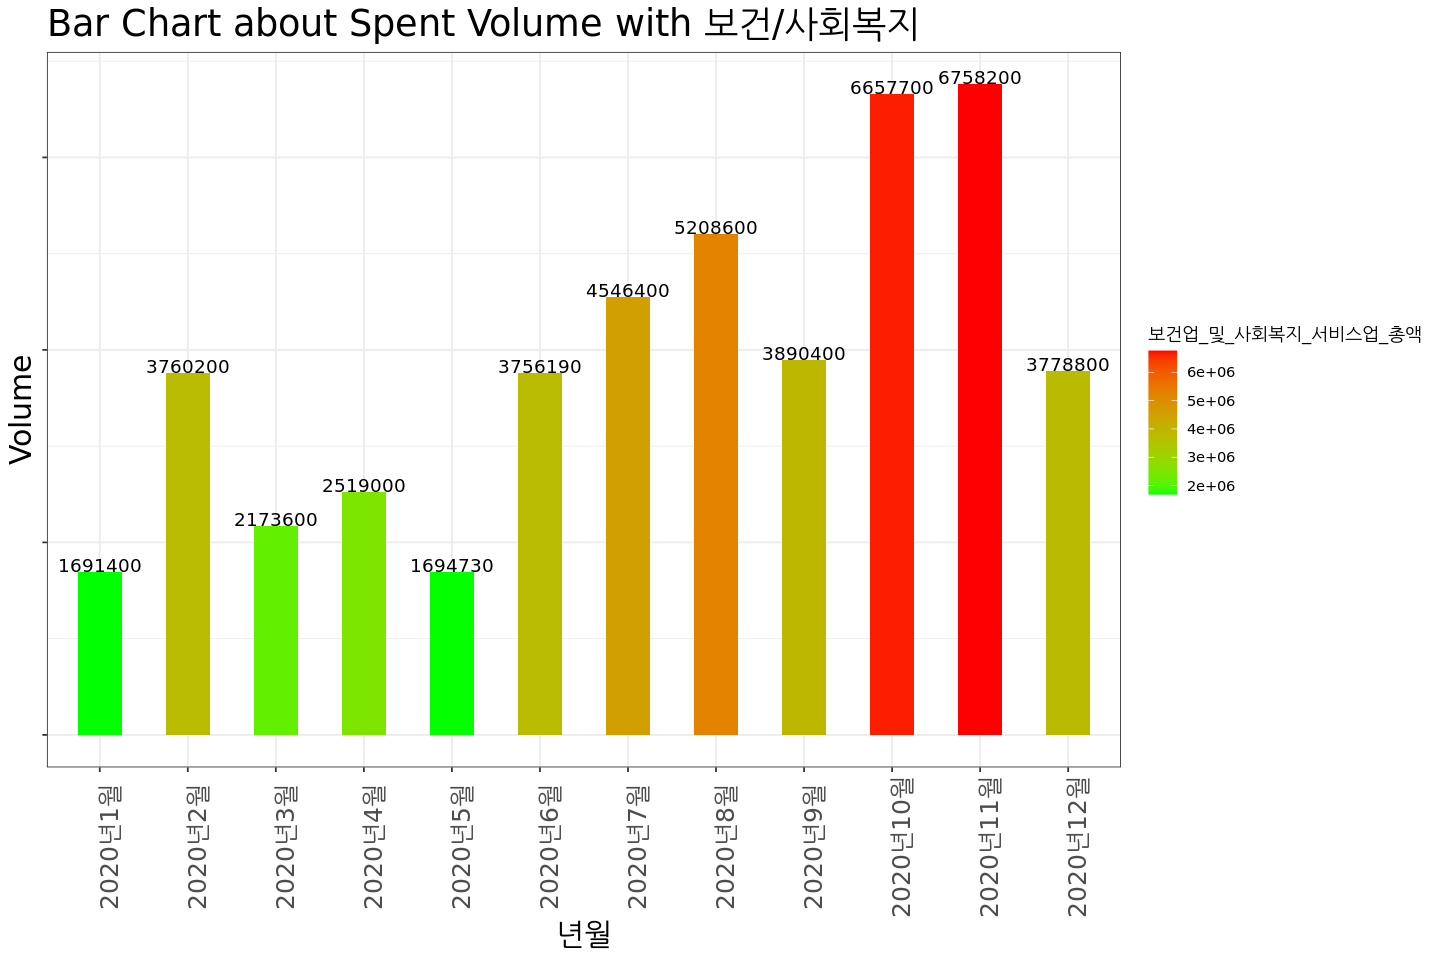

In [32]:
fig(12,8)
사회복지$년월=factor(사회복지$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(사회복지, aes(년월,보건업_및_사회복지_서비스업_총액,fill=보건업_및_사회복지_서비스업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=보건업_및_사회복지_서비스업_총액),vjust=0) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 보건/사회복지")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_blank(), axis.title=element_text(size=18))

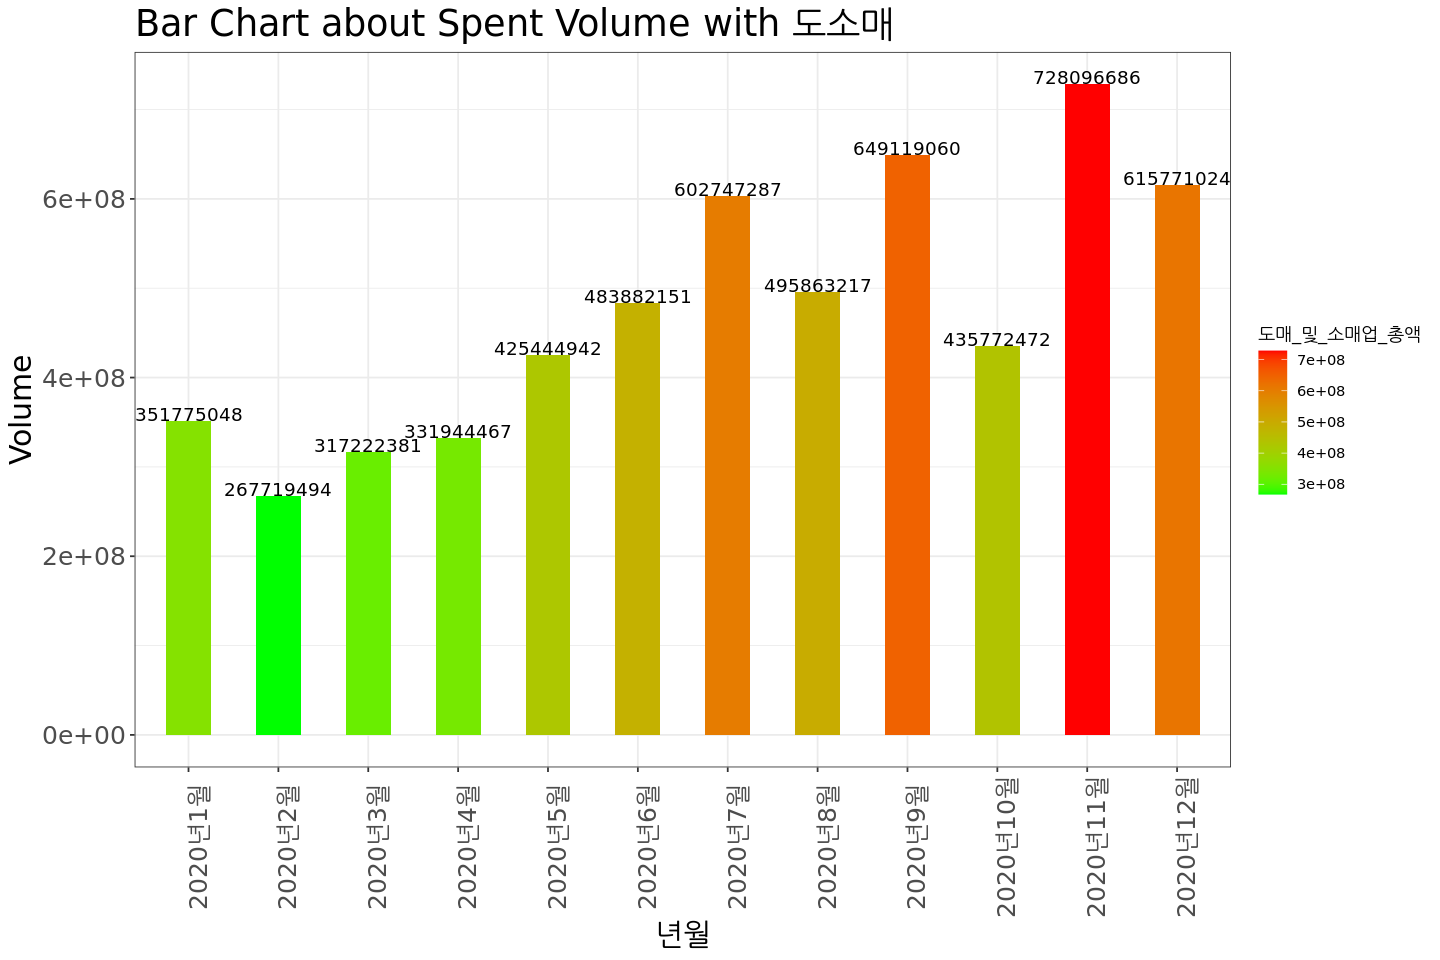

In [33]:
fig(12,8)
도소매$년월=factor(도소매$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(도소매, aes(년월,도매_및_소매업_총액,fill=도매_및_소매업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=도매_및_소매업_총액),vjust=0) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 도소매")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_text(size=15), axis.title=element_text(size=18))

In [34]:
# mask=(card$동=='성남동'|card$동=='정림동'|card$동=='문창동'|card$동=='대흥동')

mask=(card$동=='정림동')

교육=card[mask,c(1,3,8,9,10,11)]
금융=card[mask,c(1,3,12,13,14,15)]
기타=card[mask,c(1,3,16,17,18,19)]
도소매=card[mask,c(1,3,20,21,22,23)]
사회복지=card[mask,c(1,3,24,25,26,27)]
부동산=card[mask,c(1,3,28,29,30,31)]
사업지원=card[mask,c(1,3,32,33,34,35)]
숙박음식=card[mask,c(1,3,36,37,38,39)]
여가=card[mask,c(1,3,40,41,42,43)]
운수=card[mask,c(1,3,44,45,46,47)]
과학기술=card[mask,c(1,3,48,49,50,51)]
정보통신=card[mask,c(1,3,52,53,54,55)]
제조업=card[mask,c(1,3,56,57,58,59)]
협회=card[mask,c(1,3,60,61,62,63)]

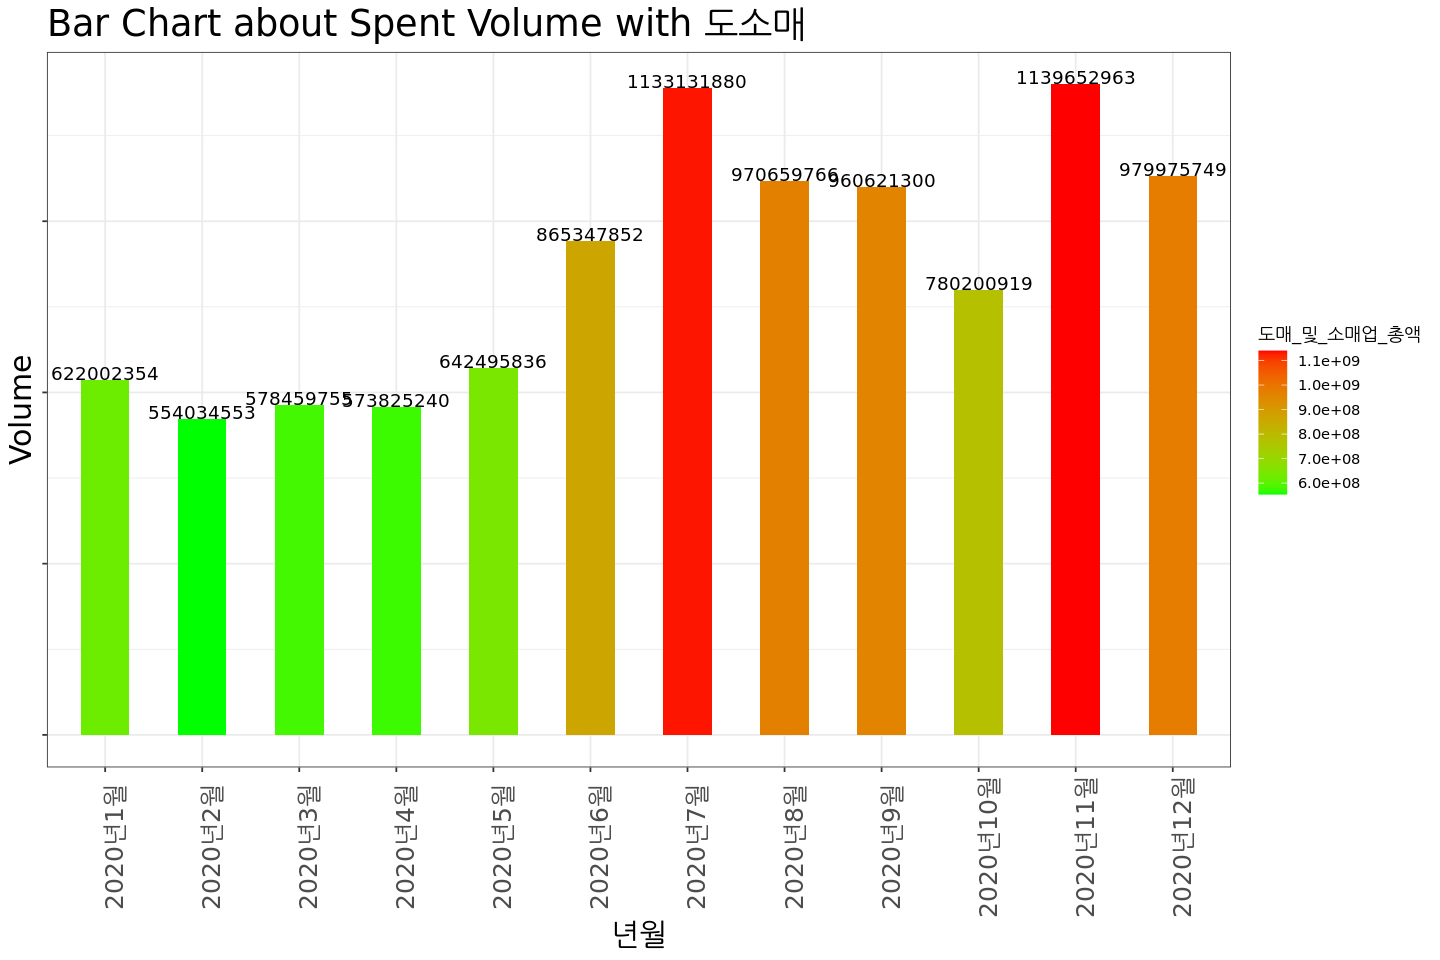

In [35]:
fig(12,8)
도소매$년월=factor(도소매$년월,levels=c('2020년1월','2020년2월','2020년3월','2020년4월','2020년5월',
                          '2020년6월','2020년7월','2020년8월','2020년9월','2020년10월','2020년11월','2020년12월'))

ggplot(도소매, aes(년월,도매_및_소매업_총액,fill=도매_및_소매업_총액))+
geom_bar(stat="identity", width = 0.5)+
geom_text(aes(label=도매_및_소매업_총액),vjust=0) +
scale_fill_gradient(low = "green", high = "red")+
 labs(x="년월",y="Volume",title="Bar Chart about Spent Volume with 도소매")+ 
theme_bw()+
theme(plot.title = element_text(size=22),axis.text.x= element_text(size=15,angle=90),
                            axis.text.y= element_blank(), axis.title=element_text(size=18))